# Importing libraries

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from tqdm import tqdm

# Model definition

In [2]:
class VariationalAutoEncoder(nn.Module):
  def __init__(self, input_dim, h_dim, z_dim):
    super().__init__()
    # encoder
    self.img_2hid = nn.Linear(input_dim, h_dim)
    self.hid_2mu = nn.Linear(h_dim, z_dim)
    self.hid_2sigma = nn.Linear(h_dim, z_dim)

    # decoder
    self.z_2hid = nn.Linear(z_dim, h_dim)
    self.hid_2img = nn.Linear(h_dim, input_dim)

    self.relu = nn.ReLU()                                 # activation func in hidden layers

  def encode(self, x):
    h = self.relu(self.img_2hid(x))
    mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
    return mu, sigma

  def decode(self, z):
    h = self.relu(self.z_2hid(z))
    return self.hid_2img(h)

  def forward(self, x):
    mu, sigma = self.encode(x)
    epsilon = torch.randn_like(sigma)
    z_new = mu + sigma*epsilon                            # reparameterization trick
    x_reconstructed = self.decode(z_new)
    return x_reconstructed, mu, sigma

# Luca experiments (representing data by hour)

### Data import

In [3]:

sel_zone = 'IT_NORD'
df_features = pd.read_csv('lcpb_files/IT_NORD_VAE_input.csv') # vae training (input features X)
df_labels = pd.read_csv(f'output/{sel_zone}_classification_input.csv') # regression training/test
df_labels= df_labels[['date_time','time','ratio','wind_installed','hydro_installed','solar_installed']]

# keeping only the ones in common
df_labels['date_time'] = pd.to_datetime(df_labels['date_time']).dt.tz_localize(None)
df_features['date_time'] = pd.to_datetime(df_features['timestamp']).dt.tz_localize(None)
common = pd.merge(df_features, df_labels, on='date_time', how = 'inner')
df_labels = common[df_labels.columns]
df_features = common[df_features.columns]
print(np.shape(df_features),np.shape(df_labels))


thresholds = [1./6,2./6,3./6]
df_labels['class'] = [1 if x < thresholds[0] else
                      2 if x >= thresholds[0] and x < thresholds[1] else
                      3 if x >= thresholds[1] and x < thresholds[2] else
                      4 for x in df_labels['ratio']]


(8320, 129) (8320, 6)


/tmp/ipykernel_11881/1575925019.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels['class'] = [1 if x < thresholds[0] else


In [4]:
# keeping only dayofthe year
df = df_features
features = ['day_sin_t0','day_cos_t0',
           'day_sin_t1','day_cos_t1',
           'day_sin_t2','day_cos_t2',
           'day_sin_t3','day_cos_t3',
           'day_sin_t4','day_cos_t4',
           'day_sin_t5','day_cos_t5',
           'day_sin_t6','day_cos_t6',
           'day_sin_t7','day_cos_t7',
           'day_sin_t8','day_cos_t8',
           'month_sin_t0','month_cos_t0',
           'month_sin_t1','month_cos_t1',
           'month_sin_t2','month_cos_t2',
           'month_sin_t3','month_cos_t3',
           'month_sin_t4','month_cos_t4',
           'month_sin_t5','month_cos_t5',
           'month_sin_t6','month_cos_t6',
           'month_sin_t7','month_cos_t7',
           'month_sin_t8','month_cos_t8']

# in alternative one can use the following lines to keep day and month
'''
features = ['sin_dayofyear_t0','cos_dayofyear_t0',
            'sin_dayofyear_t1','cos_dayofyear_t1',
            'sin_dayofyear_t2','cos_dayofyear_t2',
            'sin_dayofyear_t3','cos_dayofyear_t3',
            'sin_dayofyear_t4','cos_dayofyear_t4',
            'sin_dayofyear_t5','cos_dayofyear_t5',
            'sin_dayofyear_t6','cos_dayofyear_t6',
            'sin_dayofyear_t7','cos_dayofyear_t7',
            'sin_dayofyear_t8','cos_dayofyear_t8'
            ]
'''

df = df.drop(columns = features)
timestamp = pd.to_datetime(df['timestamp'])

timestamp_backup = timestamp.copy()

################################################
# SOFIA
# questo vettore (timestamp) è quello che puoi usare per colorare diversamente i punti secondo un certo criterio
# al momento sta usando i dati di produzione di noemi (quelli un po' scrausi)
# se vuoi vedere cosa succede per le diverse stagioni puoi provare a cambiare con queste righe:
#timestamp = timestamp.dt.hour
#timestamp = [1 if x in [1,2,3] else 2 if x in [4,5,6] else 3 if x in [7,8,9] else 4 if x in [10,11,12] for x in timestamp]
timestamp = df_labels['class']
# una volta che hai buttato dentro quello che vuoi fai andare il codice (se non va fai andare anche la cella
# sopra che c'è un drop qui)
##################################################
# to save indexes for plotting later
timestamp_tensor = torch.tensor(timestamp, dtype = torch.float32)  # Encodes strings to integers

df.drop('timestamp', axis=1, inplace=True)

print("Input Dataframe Dim:", df.shape)
df


Input Dataframe Dim: (8320, 92)


,Unnamed: 0,year_t0,2t_t0,solar_t0,tp_t0,ws_10m_t0,ws_100m_t0,hour_sin_t0,hour_cos_t0,sin_dayofyear_t0,...,2t_t8,solar_t8,tp_t8,ws_10m_t8,ws_100m_t8,hour_sin_t8,hour_cos_t8,sin_dayofyear_t8,cos_dayofyear_t8,date_time
0,0,-1.224855,-1.266622,-0.785197,-0.540314,-0.169929,0.237315,0.249009,1.890047,0.025562,...,-1.279364,-0.785204,-0.539696,-0.982129,-1.132097,-0.685682,1.408711,0.025586,1.291842,2022-01-01 00:00:00
1,1,-1.224855,-1.324489,-0.785197,-0.540314,-0.167036,0.001132,1.183829,1.408519,0.025562,...,-1.305169,-0.785204,-0.539696,-0.791966,-0.931334,0.249115,1.890286,0.050415,1.291222,2022-01-01 03:00:00
2,2,-1.224855,-1.363120,-0.691746,-0.543042,-0.218606,-0.093139,1.571044,0.246007,0.025562,...,-1.369257,-0.785204,-0.539696,-0.709343,-0.778698,1.183912,1.408711,0.050415,1.291222,2022-01-01 06:00:00
3,3,-1.224855,-1.091436,0.355950,-0.543042,-0.396948,-0.530006,1.183829,-0.916506,0.025562,...,-1.427837,-0.704916,-0.537695,-0.616626,-0.664870,1.571118,0.246088,0.050415,1.291222,2022-01-01 09:00:00
4,4,-1.224855,-0.496955,0.545301,-0.543042,-0.719834,-0.962998,0.249009,-1.398034,0.025562,...,-1.170501,0.196247,-0.537695,-0.573833,-0.452988,1.183912,-0.916535,0.050415,1.291222,2022-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8315,8315,1.224561,-0.453550,-0.478673,-0.546437,-1.220757,-1.408609,-0.685811,-0.916506,-0.024044,...,-0.518011,0.586399,-0.545575,-1.441098,-1.518295,0.249115,-1.398110,0.000749,1.292048,2024-12-30 15:00:00
8316,8316,1.224561,-1.110274,-0.785197,-0.545773,-1.125086,-1.549938,-1.073026,0.246007,-0.024044,...,-0.567924,-0.485478,-0.545575,-1.249467,-1.388240,-0.685682,-0.916535,0.000749,1.292048,2024-12-30 18:00:00
8317,8317,1.224561,-1.110274,-0.785197,-0.545773,-1.125086,-1.549938,-1.073026,0.246007,-0.024044,...,-1.247314,-0.785204,-0.544950,-1.301211,-1.439442,-1.072887,0.246088,0.000749,1.292048,2024-12-30 18:00:00
8318,8318,1.224561,-1.322641,-0.785197,-0.545773,-1.180936,-1.527834,-0.685811,1.408519,-0.024044,...,-1.247314,-0.785204,-0.544950,-1.301211,-1.439442,-1.072887,0.246088,0.000749,1.292048,2024-12-30 21:00:00


In [5]:
# Custom Dataset
class TabularDataset(torch.utils.data.Dataset):
  def __init__(self, data_tensor, timestamp_tensor):
    self.data = data_tensor
    self.timestamp = timestamp_tensor

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, index):
    return self.data[index], 0, self.timestamp[index]                              # dummy label for compatibility

# Load and preprocess CSV data
#df = pd.read_csv("IT_NORD_VAE_input.csv")
#df.drop('timestamp', axis=1, inplace=True)
df = df.drop(columns = ['date_time','Unnamed: 0'])

data_tensor = torch.tensor(df.values, dtype=torch.float32)

# Split the dataset into train, val, test
dataset = TabularDataset(data_tensor, timestamp_tensor)

total_size = len(dataset)
train_size = int(0.7 * total_size)                               # %70 training, %15 validation and %15 test
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# order preserving data split
from torch.utils.data import Subset

# Compute sizes
total_size = len(dataset)
train_end = int(train_size)
val_end = train_end + int(val_size)

# Create sequential indices
indices = list(range(total_size))

# Create subsets without shuffling
dataset = TabularDataset(data_tensor, timestamp_tensor)
train_dataset = Subset(dataset, indices[:train_end])
val_dataset = Subset(dataset, indices[train_end:val_end])
test_dataset = Subset(dataset, indices[val_end:])

print("Input Dataframe Dim:", df.shape)

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

Input Dataframe Dim: (8320, 90)


### Training 

In [6]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_DIM = data_tensor.shape[1]
H_DIM = 64
NUM_EPOCHS = 50
BATCH_SIZE = 128
LR_RATE = 1e-3
Z_DIM_VALUES = [5]

all_histories = {}

for Z_DIM in Z_DIM_VALUES:
  print(f"\nTraining with Z_DIM = {Z_DIM}")
  model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
  optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
  loss_fn = nn.MSELoss(reduction="sum")

  history = {
      'total_loss': [],
      'reconstruction_loss': [],
      'kl_div': [],
      'val_total_loss': [],
      'val_reconstruction_loss': [],
      'val_kl_div': [],
      'test_loss': None
  }
  outputs = []

  for epoch in range(NUM_EPOCHS):
    epoch_total = 0
    epoch_recon = 0
    epoch_kl = 0
    num_samples = 0

    model.train()
    loop = tqdm(train_loader, desc=f"Z_DIM = {Z_DIM} | Epoch {epoch+1}/{NUM_EPOCHS}")

    for i, (x_batch, _, _) in enumerate(loop):
      x_batch = x_batch.to(DEVICE)
      x_reconstructed, mu, sigma = model(x_batch)

      # Loss Function
      reconstruction_loss = loss_fn(x_reconstructed, x_batch)
      logvar = torch.log(sigma.pow(2) + 1e-8)
      kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      loss = reconstruction_loss + kl_div

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loop.set_postfix(
          total_loss=loss.item() / x_batch.shape[0],
          reconstruction_loss=reconstruction_loss.item() / x_batch.shape[0],
          kl_div=kl_div.item() / x_batch.shape[0])

      epoch_total += loss.item()
      epoch_recon += reconstruction_loss.item()
      epoch_kl += kl_div.item()
      num_samples += x_batch.shape[0]

      if i == 0:
        outputs.append((epoch, x_batch.clone(), x_reconstructed.clone()))

    # Compute and store averages after each epoch
    history['total_loss'].append(epoch_total / num_samples)
    history['reconstruction_loss'].append(epoch_recon / num_samples)
    history['kl_div'].append(epoch_kl / num_samples)

    # Validation step
    model.eval()
    val_total = 0
    val_recon = 0
    val_kl = 0
    val_samples = 0

    with torch.no_grad():
      for x_val, _ , _ in val_loader:
        x_val = x_val.to(DEVICE)
        x_reconstructed, mu, sigma = model(x_val)
        loss_rec = loss_fn(x_reconstructed, x_val)
        logvar = torch.log(sigma.pow(2) + 1e-8)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = loss_rec + kl_div

        val_total += loss.item()
        val_recon += loss_rec.item()
        val_kl += kl_div.item()
        val_samples += x_val.size(0)

    history['val_total_loss'].append(val_total / val_samples)
    history['val_reconstruction_loss'].append(val_recon / val_samples)
    history['val_kl_div'].append(val_kl / val_samples)

    # Visualize latent space (t-SNE for high space visualization) (or PCA)
    
    if (epoch == (NUM_EPOCHS - 1)):
        model.eval()
        with torch.no_grad():
            zs = []
            ts = []
            for x_batch, _ , timestamp_batch in train_loader:
                x_batch = x_batch.to(DEVICE)
                mu, sigma = model.encode(x_batch)
                zs.append(mu.cpu().numpy())
                ts.append(timestamp_batch.numpy())
            zs = np.concatenate(zs, axis = 0)
            ts = np.concatenate(ts, axis = 0)

            # check for unique values
            unique_ts = np.unique(ts)
            ts_to_idx = {v: i for i, v in enumerate(unique_ts)}
            ts_idx = np.array([ts_to_idx[t] for t in ts])

            '''# Reduce to 2D
            if Z_DIM > 2:
                reducer = TSNE(n_components=2, perplexity=30, init='random', random_state=0)
                zs_2d = reducer.fit_transform(zs)
            else:
                zs_2d = zs

            plt.figure(figsize=(6, 5))
            scatter = plt.scatter(
                zs_2d[:, 0], zs_2d[:, 1],
                c=ts, cmap='tab20',  # Color by timestamp category
                alpha=0.6, s=5
            )
            plt.colorbar(scatter, label="Timestamp Category")
            plt.title(f"2D Projection of Latent Space at Epoch {epoch + 1} (Z_DIM={Z_DIM})")
            plt.xlabel("Component 1")
            plt.ylabel("Component 2")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            plt.close()'''

  # Final test set evaluation
  model.eval()
  test_loss = 0
  test_samples = 0
  with torch.no_grad():
    for x_test, _ , _ in test_loader:
      x_test = x_test.to(DEVICE)
      x_reconstructed, mu, sigma = model(x_test)
      loss_rec = loss_fn(x_reconstructed, x_test)
      logvar = torch.log(sigma.pow(2) + 1e-8)
      kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      loss = loss_rec + kl_div
      test_loss += loss.item()
      test_samples += x_test.shape[0]

  history['test_loss'] = test_loss / test_samples
  print(f"Final Test Loss for Z_DIM = {Z_DIM}: {history['test_loss']:.4f}")

  all_histories[Z_DIM] = history


Training with Z_DIM = 5


Z_DIM = 5 | Epoch 1/50: 100%|█| 46/46 [00:00<00:00, 175.34it/s, kl_div=4.35, rec
Z_DIM = 5 | Epoch 2/50: 100%|█| 46/46 [00:00<00:00, 183.23it/s, kl_div=7.23, rec
Z_DIM = 5 | Epoch 3/50: 100%|█| 46/46 [00:00<00:00, 188.91it/s, kl_div=8.75, rec
Z_DIM = 5 | Epoch 4/50: 100%|█| 46/46 [00:00<00:00, 178.58it/s, kl_div=8.47, rec
Z_DIM = 5 | Epoch 5/50: 100%|█| 46/46 [00:00<00:00, 174.73it/s, kl_div=9.19, rec
Z_DIM = 5 | Epoch 6/50: 100%|█| 46/46 [00:00<00:00, 176.89it/s, kl_div=9.31, rec
Z_DIM = 5 | Epoch 7/50: 100%|█| 46/46 [00:00<00:00, 188.13it/s, kl_div=8.93, rec
Z_DIM = 5 | Epoch 8/50: 100%|█| 46/46 [00:00<00:00, 185.16it/s, kl_div=9.55, rec
Z_DIM = 5 | Epoch 9/50: 100%|█| 46/46 [00:00<00:00, 193.06it/s, kl_div=9.29, rec
Z_DIM = 5 | Epoch 10/50: 100%|█| 46/46 [00:00<00:00, 172.92it/s, kl_div=9.35, re
Z_DIM = 5 | Epoch 11/50: 100%|█| 46/46 [00:00<00:00, 193.24it/s, kl_div=8.8, rec
Z_DIM = 5 | Epoch 12/50: 100%|█| 46/46 [00:00<00:00, 185.91it/s, kl_div=9.23, re
Z_DIM = 5 | Epoch 13/50: 100

Final Test Loss for Z_DIM = 5: 38.3417


# Attempt to use PCA for representing hidden space

In [7]:
np.unique(ts)

array([1., 2., 3., 4.], dtype=float32)

(5824, 5)


<Figure size 750x500 with 0 Axes>

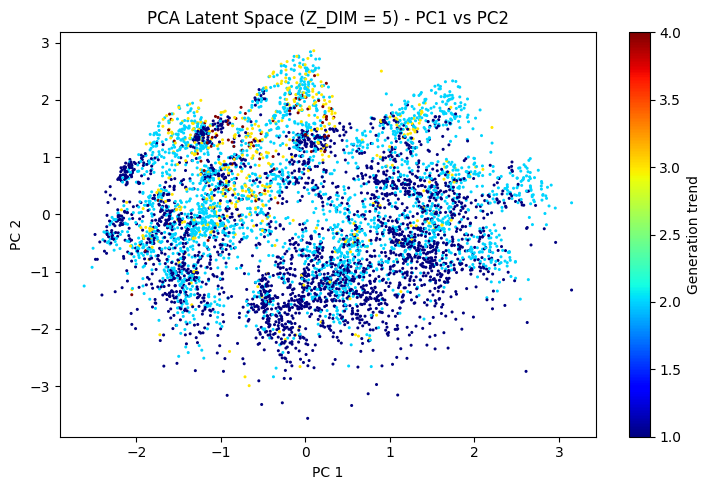

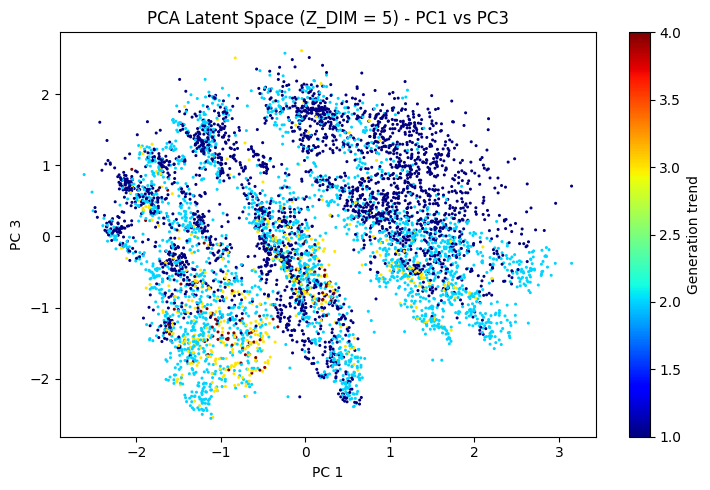

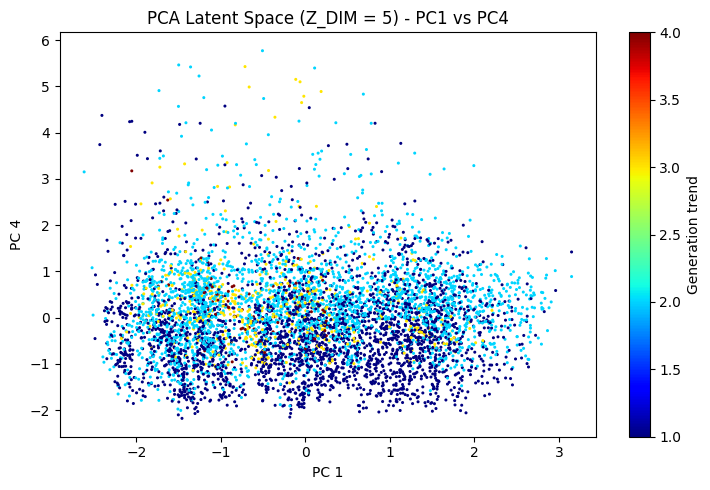

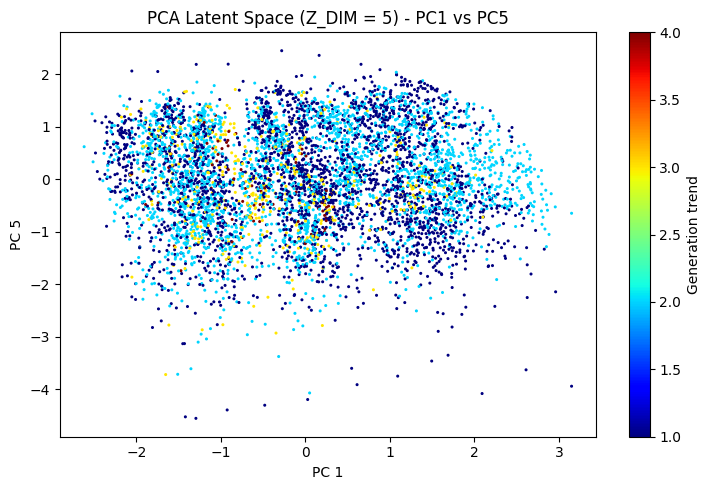

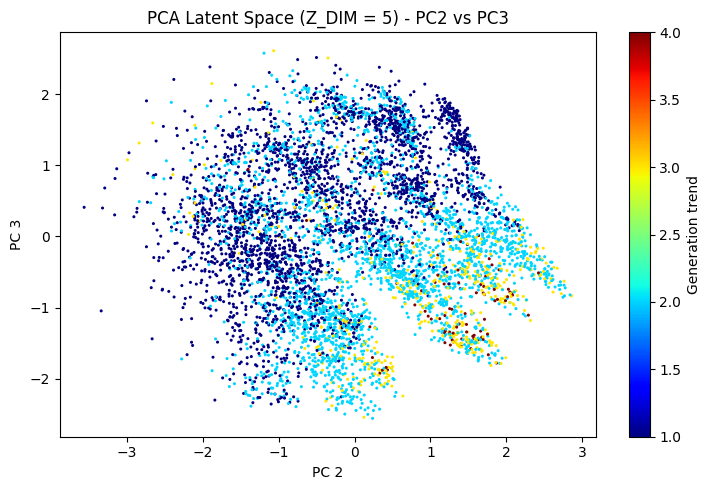

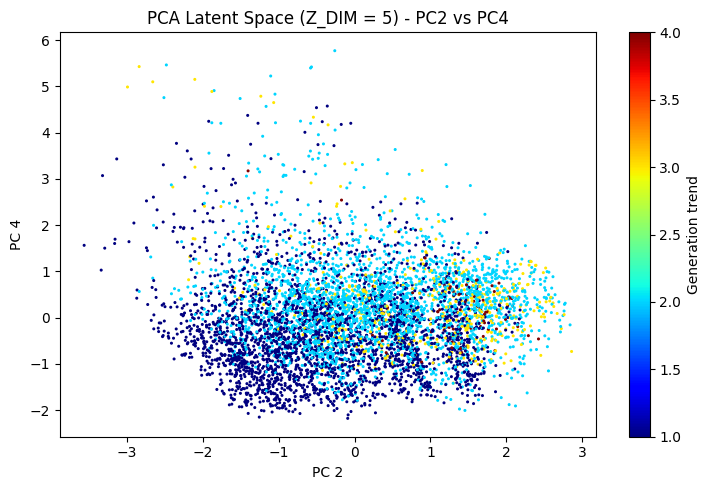

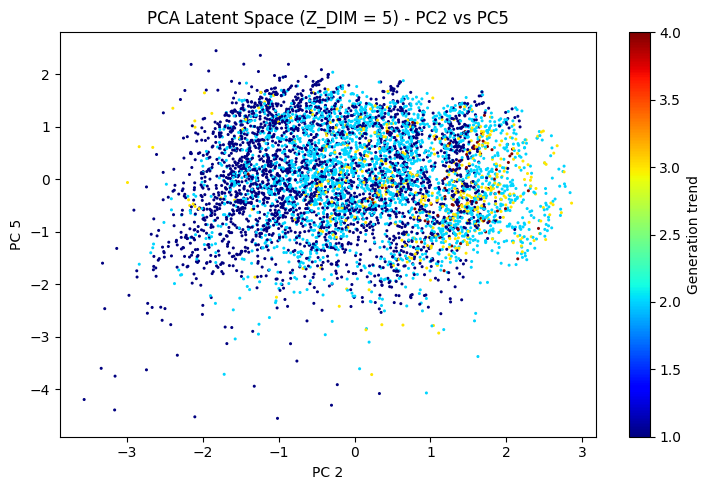

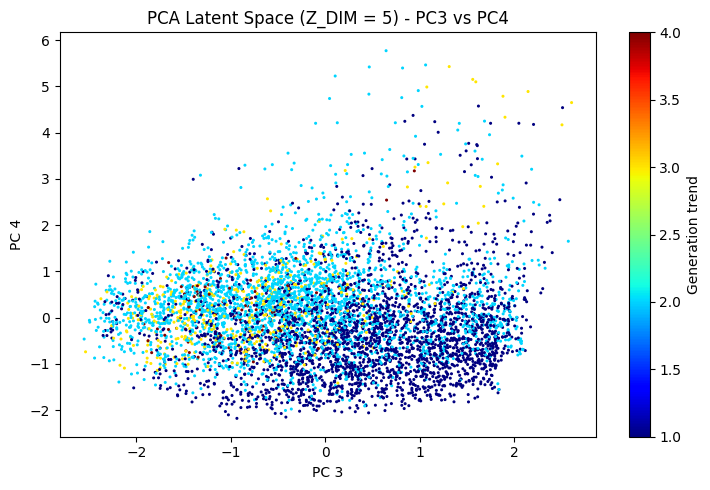

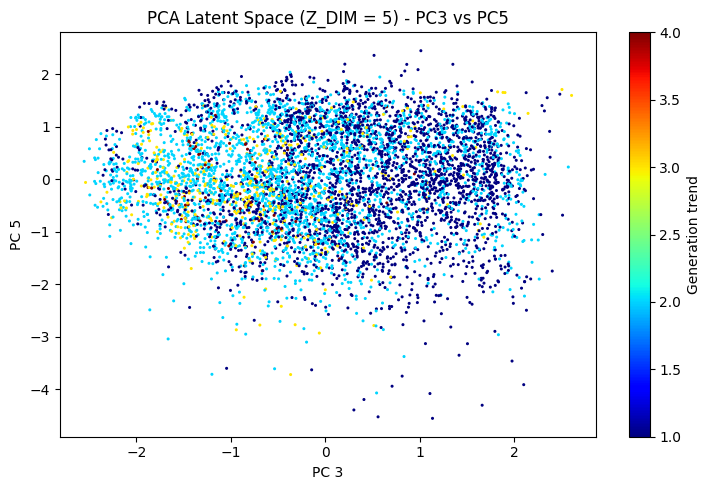

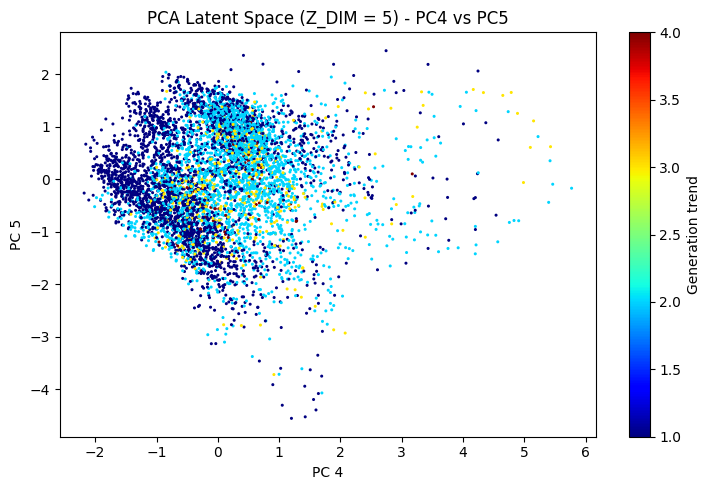

In [8]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import itertools

X = zs
pca = PCA(n_components = 5)
zs_pca = pca.fit_transform(zs)
#print(zs_pca.explained_variance_ratio_)
print(np.shape(zs_pca))
plt.figure(figsize = (7.5, 5))


############################
# SOFIA
# qui ci sono un paio di cose che dovresti ritoccare per i plot
# colors handling
unique_ts = np.unique(ts)
# vengono usati solo i primi n colori (dove n numero di diverse categorie in timestamp
custom_colors = ['blue','green', 'orange','#006064','lightblue','#1B5E20', 'green', 'brown','orange','yellow','pink','red','#FFEB3B','#FAF4C4','#FAF4C4',]  
keep_colors = custom_colors[:len(unique_ts)]
custom_colormap = ListedColormap(custom_colors[:len(unique_ts)])
# legend
# qui dovresti scrivere a mano a che cosa corrisponde ogni categoria
# custom_labels = ['winter','spring','summer','autumn']
custom_labels = ['underproduction',
                 'balanced',
                 'overproduction']
#############################
#legend_handles = [
#    Patch(color=keep_colors[i], label=custom_labels[i]) for i in range(len(unique_ts))
#]

# Plot all 2D combinations of PCA components
combinations = list(itertools.combinations(range(zs_pca.shape[1]), 2))
for i, (x_idx, y_idx) in enumerate(combinations):
    plt.figure(figsize=(7.5, 5))
    
    scatter = plt.scatter(zs_pca[:, x_idx], zs_pca[:, y_idx], c=ts, cmap='jet', s=1.4)
    
    plt.title(f"PCA Latent Space (Z_DIM = {Z_DIM}) - PC{x_idx+1} vs PC{y_idx+1}")
    plt.xlabel(f"PC {x_idx+1}")
    plt.ylabel(f"PC {y_idx+1}")
    #plt.legend(handles=legend_handles, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.colorbar(label='Generation trend')
    plt.tight_layout()
    plt.savefig(f"PCA_output/ZDIM_{Z_DIM}_PC{x_idx}_{y_idx}.png")
    plt.show()

In [9]:
pca.explained_variance_ratio_

array([0.2568399 , 0.22434187, 0.19461791, 0.16707885, 0.15712146],
      dtype=float32)

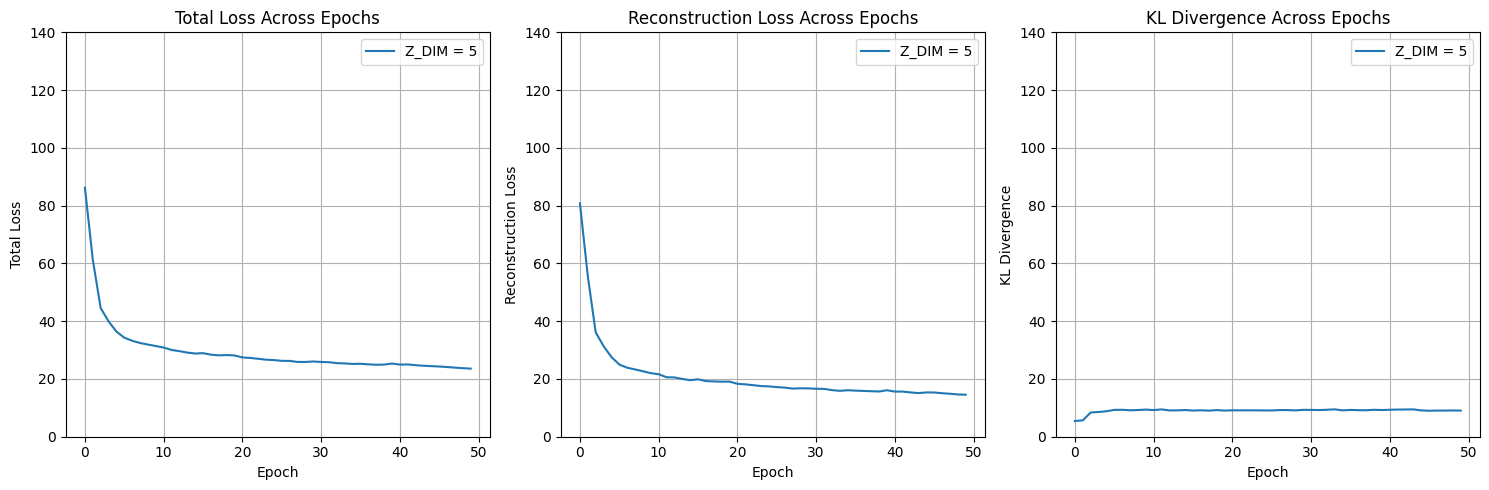

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
ymin, ymax = 0, 140

# Plot of Total Loss
for z_dim, history in all_histories.items():
  axs[0].plot(history['total_loss'], label=f"Z_DIM = {z_dim}")
  axs[0].set_ylabel("Total Loss")
  axs[0].set_xlabel("Epoch")
  axs[0].set_title("Total Loss Across Epochs")
  axs[0].set_ylim(ymin, ymax)
  axs[0].legend()
  axs[0].grid(True)

# Plot of Reconstruction Loss
for z_dim, history in all_histories.items():
  axs[1].plot(history['reconstruction_loss'], label=f"Z_DIM = {z_dim}")
  axs[1].set_ylabel("Reconstruction Loss")
  axs[1].set_xlabel("Epoch")
  axs[1].set_title("Reconstruction Loss Across Epochs")
  axs[1].set_ylim(ymin, ymax)
  axs[1].legend()
  axs[1].grid(True)

# Plot of KL Divergence
for z_dim, history in all_histories.items():
  axs[2].plot(history['kl_div'], label=f"Z_DIM = {z_dim}")
  axs[2].set_xlabel("Epoch")
  axs[2].set_ylabel("KL Divergence")
  axs[2].set_title("KL Divergence Across Epochs")
  axs[2].set_ylim(ymin, ymax)
  axs[2].legend()
  axs[2].grid(True)

plt.tight_layout()
plt.show()

In [11]:
print(f"{'Z_DIM':<8} {'Total Loss':<13} {'Recon Loss':<13} {'KL-Divergence':<13}")
for z_dim, history in all_histories.items():
  print(f"{z_dim:<8} {history['total_loss'][-1]:<13.2f} {history['reconstruction_loss'][-1]:<13.2f} {history['kl_div'][-1]:<13.2f}")

Z_DIM    Total Loss    Recon Loss    KL-Divergence
5        23.58         14.54         9.04         


# Attack a NN in tail

### Model

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleClassifier(nn.Module):
    def __init__(self, z_dim, x_extra_dim, hidden_dims, output_dim):
        super(SimpleClassifier, self).__init__()
        input_dim = z_dim + x_extra_dim

        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.output = nn.Linear(hidden_dims[1], output_dim)
        self.relu = nn.ReLU()

    def forward(self, zs, x_extra):
        #print('zs:', zs.shape, 'x_extra:', x_extra.shape)

        x = torch.cat((zs, x_extra), dim=1)  # concatenate along feature dimension
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        logits = self.output(x)
        return logits

### Data preparation

In [57]:
class CombinedDataset(Dataset):
    def __init__(self, zs_tensor, X_extra, Y):
        self.zs = zs_tensor
        self.X_extra = X_extra
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.zs[idx], self.X_extra[idx], self.Y[idx]

In [58]:
# compute all hidden vectors

model.eval()  # set to evaluation mode
device = 'cpu'
data_tensor = data_tensor.to(device)  # move input to same device as model

with torch.no_grad():
    mu, logvar = model.encode(data_tensor)
    zs = mu.cpu().numpy()

print(np.shape(zs))


(8320, 5)


In [59]:
print(np.shape(df_labels))

(8320, 7)


In [60]:
# zs are the latent space resulting vectors
# we need to attach to them the corresponding labels

X_extra = torch.tensor(df_labels.drop(columns=['class','date_time','ratio']).values, dtype=torch.float32)  # replace 'label' with your actual label column
Y = torch.tensor(df_labels['class'].values, dtype=torch.long)  # or float if regression
print(torch.unique(Y))


if isinstance(zs, np.ndarray):
    zs_tensor = torch.tensor(zs, dtype=torch.float32)
else:
    zs_tensor = zs  # already a tensor

full_dataset = CombinedDataset(zs_tensor, X_extra, Y)

total_size = len(full_dataset)
train_end = int(0.7 * total_size)
val_end = train_end + int(0.15 * total_size)

indices = list(range(total_size))

train_dataset = Subset(full_dataset, indices[:train_end])
val_dataset = Subset(full_dataset, indices[train_end:val_end])
test_dataset = Subset(full_dataset, indices[val_end:])

print('zs_tensor shape:', zs_tensor.shape)       # e.g. (N, z_dim)
print('X_extra shape:', X_extra.shape)     

z_dim = zs_tensor.shape[1]
x_extra_dim = X_extra.shape[1]

tensor([1, 2, 3, 4])
zs_tensor shape: torch.Size([8320, 5])
X_extra shape: torch.Size([8320, 4])


### Training the NN

In [61]:
device = 'cpu'
modelNN = SimpleClassifier(z_dim=z_dim, 
                           x_extra_dim=x_extra_dim, 
                           hidden_dims=[64, 32], 
                           output_dim=len(torch.unique(Y)) + 1
                          ).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelNN.parameters(), lr=1e-3)

num_epochs = 10
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0

for epoch in range(num_epochs):
    modelNN.train()
    running_loss = 0.0

    for zs, X_extra, labels in train_loader:
        zs = zs.to(device)
        X_extra = X_extra.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = modelNN(zs, X_extra)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * zs.size(0)

        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
accuracy = 100 * correct / total

Epoch [1/10], Loss: 1.1371
Epoch [2/10], Loss: 0.7150
Epoch [3/10], Loss: 0.6334
Epoch [4/10], Loss: 0.5862
Epoch [5/10], Loss: 0.5566
Epoch [6/10], Loss: 0.5407
Epoch [7/10], Loss: 0.5285
Epoch [8/10], Loss: 0.5201
Epoch [9/10], Loss: 0.5135
Epoch [10/10], Loss: 0.5064


In [62]:
print(accuracy)

73.98179945054945


In [63]:
for epoch in range(num_epochs):
    modelNN.eval()
    running_loss = 0.0

    for zs, X_extra, labels in test_loader:
        zs = zs.to(device)
        X_extra = X_extra.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = modelNN(zs, X_extra)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * zs.size(0)

        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
accuracy = 100 * correct / total

Epoch [1/10], Loss: 0.2291
Epoch [2/10], Loss: 0.2401
Epoch [3/10], Loss: 0.2289
Epoch [4/10], Loss: 0.1801
Epoch [5/10], Loss: 0.1615
Epoch [6/10], Loss: 0.1563
Epoch [7/10], Loss: 0.1538
Epoch [8/10], Loss: 0.1512
Epoch [9/10], Loss: 0.1490
Epoch [10/10], Loss: 0.1470


In [64]:
print(accuracy)

71.9018665158371
